## Expanding the CIP netCDFfiles and adding data from nav files
best fit the t


In [1]:
import xarray as xr # read netcdf-files
import numpy as np
import warnings
import pandas as pd
import glob # allows for wildcards in filemanagement
import os #get a list of all directories/files

In [2]:
# -- Paths to datafiles
# Local disk path of nav data:
main_path = '../2022-islas/' # directory with flight data
nav_file_struct_tdyn = '/ISLAS_SAFIRE-ATR42_CORE_TDYN_1HZ_20220322_as220007_L1_V1.nc' # structure of nav TDYN file names
nav_file_struct_nav = '/ISLAS_SAFIRE-ATR42_CORE_NAV_1HZ_20220322_as220007_L1_V1' # structure of nav NAV file names
drop_flights = ['as220005','as220006'] # flights to drop, (if not all are to be analysed 5 and 6 is in france)
    
     

cip_nc_file = '../Results_2022-islas/12sAveraging/as220007/SODA_original/03222022_113721_CIP.nc'
nav_file = '../2022-islas/as220007/ISLAS_SAFIRE-ATR42_CORE_NAV_1HZ_20220322_as220007_L1_V1.nc'

In [3]:
# function to add NAV information to CIP xarray and standardize file to CF/ACDD
# TODO: Update metadata

def standardize_cip_netcdf(cip_nc_file, nav_file, flight):
    from datetime import date
    import pandas as pd
    import xarray as xr
    
    cip_xds = xr.open_dataset(cip_nc_file) # returns an xarray dataset
    nav_xds = xr.open_dataset(nav_file) # returns an xarray dataset

    # -- UPDATE COORDINATES based on NAV file
    # Set the time variable in cip_xds as a coordinate
    cip_updated_xds = cip_xds.set_coords(('utc_time'))
    
    # get times from CIP and transform them to something that can be selected in the nav-file
    # and turn them into datetime objects
    times = cip_updated_xds.coords['utc_time'].values                    # get all the times in the CIP file
    base_time = cip_updated_xds.base_time.values.astype('datetime64[D]')      # get the basetime
    datetimes  = base_time + times.astype('timedelta64[s]')                   #transform from seconds from midnight to datetimeobject 

    # select the NAV data from these times
    sel_data = nav_xds.sel(time=datetimes, method = "nearest")           # "nearest" due to diffs in decimalseconds
    # Add NAV coordinates to the CIP xarray
    cip_updated_xds = cip_updated_xds.assign_coords(sel_data.coords)

    # -- UPDATE METADATA

    # ISLAS id
    cip_updated_xds.attrs['islasid'] = flight

    # Global metadata
    #ACDD Highly recommended
    cip_updated_xds.attrs['title'] = f'CIP dataset from flight {flight} of the ISLAS campaign'
    cip_updated_xds.attrs['summary'] = f'SODA2 Processed CIP data from flight {flight} from the ISLAS 2022 campain. Updated with latitude, longitude, altitude and time coordinates from the flights NAV data'
    cip_updated_xds.attrs['keywords'] = ['Earth Science > Atmosphere > Clouds > Cloud Microphysics > Cloud Liquid Water/Ice',
                                        'Earth Science > Atmosphere > Clouds > Cloud Microphysics > Cloud Droplet Concentration/Size']
    cip_updated_xds.attrs['keywords_vocabulary'] = "GCMD Science Keywords"
    cip_updated_xds.attrs['Conventions'] = ''

    # Global metadata - ACDD recommended

    # Global metadata - suggested
    cip_updated_xds.attrs['date_modified'] = date.today().strftime("%Y-%m-%d")
    cip_updated_xds.attrs['date_metadata_modified'] = date.today().strftime("%Y-%m-%d")

    return cip_updated_xds

In [4]:
cip_updated_xds = standardize_cip_netcdf(cip_nc_file, nav_file, 'IS22-01')

cip_updated_xds

<xarray.Dataset> Size: 1MB
Dimensions:           (Time: 983, Vector64: 64, Vector40: 40, time: 983)
Coordinates:
    utc_time          (Time) float64 8kB 4.184e+04 4.185e+04 ... 5.362e+04
  * time              (time) datetime64[ns] 8kB 2022-03-22T11:37:21.440021 .....
    LATITUDE          (time) float32 4kB ...
    LONGITUDE         (time) float32 4kB ...
    ALTITUDE          (time) float32 4kB ...
Dimensions without coordinates: Time, Vector64, Vector40
Data variables: (12/32)
    elapsed_time      (Time) datetime64[ns] 8kB ...
    base_time         datetime64[ns] 8B 2022-03-22T11:37:21
    TAS               (Time) float32 4kB ...
    MIDBINS           (Vector64) float32 256B ...
    ACTIVETIME        (Time) float32 4kB ...
    SA                (Vector64) float32 256B ...
    ...                ...
    MVD200            (Time) float32 4kB ...
    IWC200            (Time) float32 4kB ...
    LWC200            (Time) float32 4kB ...
    AREA200           (Time) float32 4kB ...
    MEAN_AREARATIO    (Vector64, Time) float32 252kB ...
    MEAN_ASPECTRATIO  (Vector64, Time) float32 252kB ...
Attributes: (12/59)
    Source:                  SODA-2 OAP Processing Software
    DateCreated:             Thu Dec  5 15:49:33 2024
    FlightDate:              03/22/2022
    DateProcessed:           Thu Dec  5 15:48:18 2024
    TimeInterval:            11:37:21-14:53:45
    FN:                      /home/ninalar/Documents/MC2/2022-islas/as220007/...
    ...                      ...
    summary:                 SODA2 Processed CIP data from flight IS22-01 fro...
    keywords:                ['Earth Science > Atmosphere > Clouds > Cloud Mi...
    keywords_vocabulary:     GCMD Science Keywords
    Conventions:             
    date_modified:           2024-12-10
    date_metadata_modified:  2024-12-10

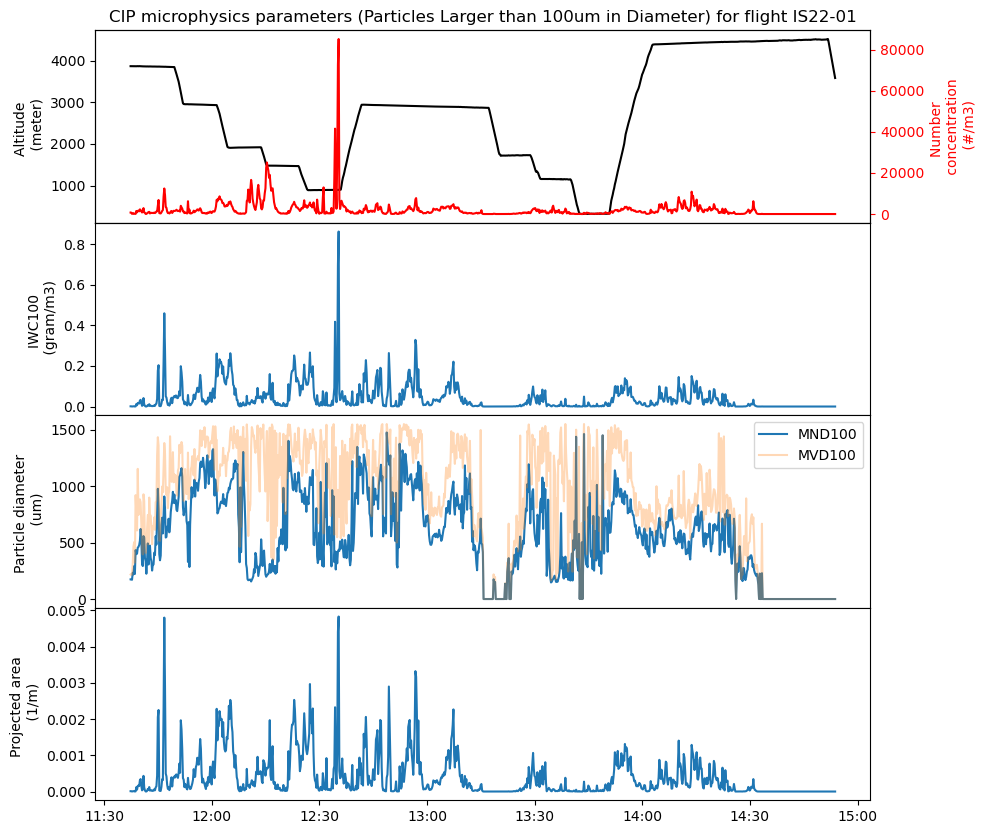

In [5]:
# plot the 100 um variables against altitude and time


import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# formatting for only showing time on the x-axis for plots per flight
# Use by setting axs[1,0].xaxis.set_major_formatter(formatter) for each axis where only time should show
formatter = mdates.DateFormatter('%H:%M')


fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10,10))
# Remove horizontal space between axes
fig.subplots_adjust(hspace=0)
axs[0].set_title(f'CIP microphysics parameters (Particles Larger than 100um in Diameter) for flight {cip_updated_xds.attrs['islasid']}')

# Plot each graph, and manually set the y tick values
axs[0].plot(cip_updated_xds.time, cip_updated_xds.ALTITUDE, c='k')
axs[0].set_ylabel(f'Altitude \n ({cip_updated_xds.ALTITUDE.units})')

axs2 = axs[0].twinx()
axs2.plot(cip_updated_xds.time, cip_updated_xds.NT100, c= 'r')
axs2.set_ylabel(f'Number \n concentration \n ({cip_updated_xds.NT100.units})', c='r')
axs2.tick_params(axis='y', colors = 'r')

axs[1].plot(cip_updated_xds.time, cip_updated_xds.IWC100)
axs[1].set_ylabel(f'IWC100 \n ({cip_updated_xds.IWC100.units})')

axs[2].plot(cip_updated_xds.time, cip_updated_xds.MND100, label = 'MND100')
axs[2].plot(cip_updated_xds.time, cip_updated_xds.MVD100, label = 'MVD100', alpha = 0.3)
axs[2].set_ylabel(f'Particle diameter \n ({cip_updated_xds.MND100.units})')
axs[2].legend()

axs[3].plot(cip_updated_xds.time, cip_updated_xds.AREA100)
axs[3].set_ylabel(f'Projected area \n ({cip_updated_xds.AREA100.units})')

axs[0].xaxis.set_major_formatter(formatter) # only show time on x-axis

plt.savefig('100microphysics_IS22-01.png')
plt.show()








In [6]:
cip_updated_xds.MEAN_ASPECTRATIO.attrs['long_name']

'Mean Aspect Ratio Per Size Bin'

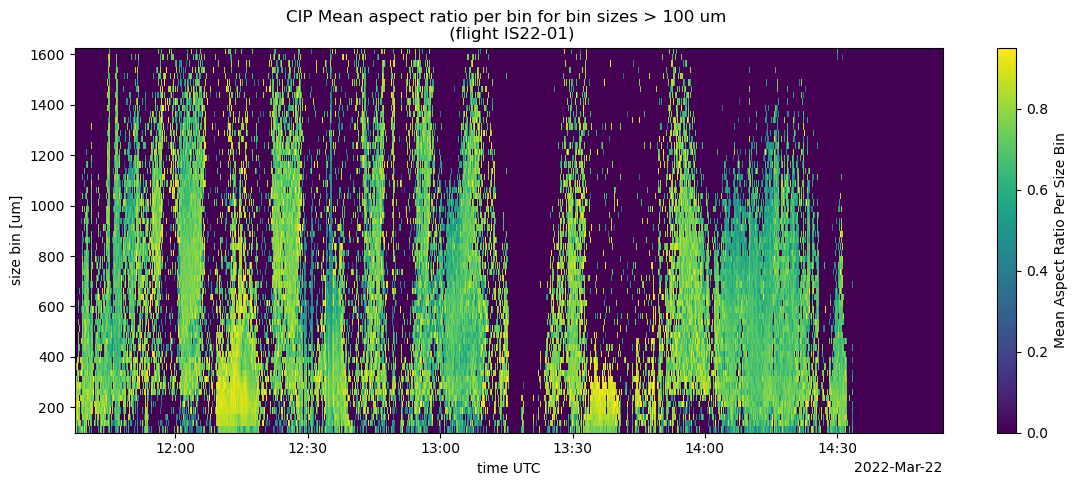

In [8]:

mas_2d_array = np.stack(cip_updated_xds.MEAN_ASPECTRATIO.values)

bin_endpoints = cip_updated_xds.MEAN_ASPECTRATIO.attrs['Bin_endpoints']
bin_endpoints = bin_endpoints[1:] # remove the first item as this is the first bin startpoint (to get lenght equal)

mas_2d_xda = xr.DataArray(
    mas_2d_array,
    coords=[bin_endpoints,cip_updated_xds["time"]],
    dims=["end_bins","time",]
)

mas_2d_xda.attrs['long_name'] = cip_updated_xds.MEAN_ASPECTRATIO.attrs['long_name']
mas_2d_xda.coords['end_bins'].attrs['long_name'] = 'size bin'
mas_2d_xda.coords['end_bins'].attrs['unit'] = 'um'

# Filter DataArray to include only end_bins > 100
mas_2d_xda_filtered = mas_2d_xda.sel(end_bins=mas_2d_xda.end_bins > 100)

#mas_2d_xda.plot(figsize=(14,5))
mas_2d_xda_filtered.plot(figsize=(14, 5))

plt.title(f'CIP Mean aspect ratio per bin for bin sizes > 100 um \n (flight {cip_updated_xds.attrs['islasid']})')
plt.savefig('100MeanAspectRatio_IS22-01.png')

(64, 983)


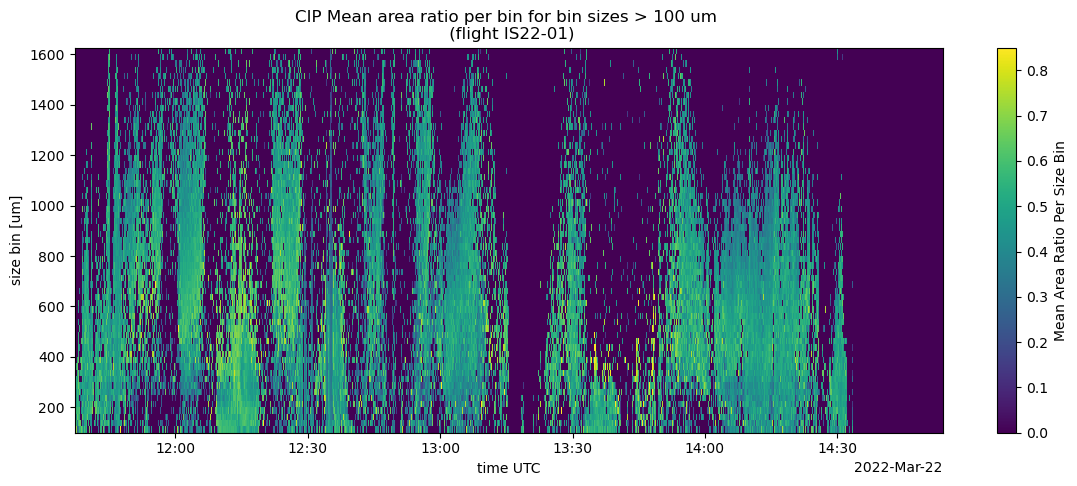

In [9]:
# plotting the Mean area ratio for the flight
mar_2d_array = np.stack(cip_updated_xds.MEAN_AREARATIO.values)

print(mar_2d_array.shape)

bin_endpoints = cip_updated_xds.MEAN_AREARATIO.attrs['Bin_endpoints']
bin_endpoints = bin_endpoints[1:] # remove the first item as this is the first bin startpoint (to get lenght equal)

mar_2d_xda = xr.DataArray(
    mar_2d_array,
    coords=[bin_endpoints,cip_updated_xds["time"]],
    dims=["end_bins","time",]
)

mar_2d_xda.attrs['long_name'] = cip_updated_xds.MEAN_AREARATIO.attrs['long_name']
mar_2d_xda.coords['end_bins'].attrs['long_name'] = 'size bin'
mar_2d_xda.coords['end_bins'].attrs['unit'] = 'um'

# Filter DataArray to include only end_bins > 100
mar_2d_xda_filtered = mar_2d_xda.sel(end_bins=mar_2d_xda.end_bins > 100)

#mar_2d_xda.plot(figsize=(14,5))
mar_2d_xda_filtered.plot(figsize=(14, 5))

plt.title(f'CIP Mean area ratio per bin for bin sizes > 100 um \n (flight {cip_updated_xds.attrs['islasid']})')
plt.savefig('100MeanAreaRatio_IS22-01.png')

In [10]:
mar_2d_array

array([[0.95      , 0.95      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.65      , 0.65      , 0.54999995, ..., 0.        , 0.        ,
        0.        ],
       [0.525     , 0.54999995, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [ ]:
# TODO: check if both files covers the same times (times in cip must be in nav)
    nav_start = pd.to_datetime(nav_xds.attrs['time_coverage_start']).tz_localize(None) #tz_localize None to make tz-naive and comparable with cip time
    nav_end = pd.to_datetime(nav_xds.attrs['time_coverage_end']).tz_localize(None)

    cip_start = pd.to_datetime(f"{cip_xds.attrs['FlightDate']} {cip_xds.attrs['TimeInterval'].split('-')[0]}", format='%m/%d/%Y %H:%M:%S')
    cip_end = pd.to_datetime(f"{cip_xds.attrs['FlightDate']} {cip_xds.attrs['TimeInterval'].split('-')[1]}", format='%m/%d/%Y %H:%M:%S')

    if (nav_start <= cip_start) & (nav_end >= cip_end) :
        # all is good
    else
        return N

In [ ]:
save_path = '../Results_2022-islas/12sAveraging/as220007/03222022_113721_CIP_update.nc'
cip_updated_xds.to_netcdf(path=save_path, mode='w')

In [ ]:
cip_updated_xds

In [ ]:
# Metadata

# Global atributes
xrds.attrs['title']='my title'

alt:
xrds.attrs = {

}
# Variable attributes
dtnow = dt.utcnow().strftime('%Y-%m-%dT%H:%M:%SZ')
xrds.attrst['date_created'] = dtnow
xrds.attrs['history'] = f'File created at {dtnow} using
xrds['latitude'].attrs = {
    'standard_name': 'latitude',
    'long_name': 'description in your own words',
    'units': 'degrees_north',
    'covaerage_content_type': 'coordinate'
}